In [209]:
from collections import defaultdict, namedtuple, Counter
import sys
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats
from os import listdir
from itertools import combinations


In [210]:
phase_dir = '../phased_spark_quads_consang'
ped_file = '../data/spark.ped'
identicals_file = '../sibpair_similarity/spark_quads_identicals.txt'
build = '38'

chroms = [str(x) for x in range(1, 23)]
#interval = 500000



In [211]:
family_key_to_num_affected = defaultdict(int)
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, aff = pieces[:6]
            if aff == '2':
                family_key_to_num_affected[(fam_id.split('.')[0], min(f_id, m_id), max(f_id, m_id))] += 1
print(Counter(family_key_to_num_affected.values()))

Counter({1: 47737, 2: 4846, 3: 532, 4: 63, 5: 9})


# How related are parents?

In [212]:
def pull_state(filename):
    states = []
    with open(filename, 'r') as f:
        header = next(f).strip().split('\t')
        individuals = [header[x].split('_')[0] for x in range(9, 17, 2)]
        states = []
        chrs = []
        mult = []
        starts = []
        ends = []
        for line in f:
            pieces = line.strip().split('\t')
            chrs.append(int(pieces[0][3:]))
            states.append(list(map(int, pieces[1:-2])))
            mult.append(int(pieces[-1])-int(pieces[-2]))
            starts.append(int(pieces[-2]))
            ends.append(int(pieces[-1]))
    return np.array(states).T, np.array(chrs), np.array(starts), np.array(ends), np.array(mult), [header[x].split('_')[0] for x in range(9, 17, 2)]

In [213]:
parents_to_share_both = defaultdict(list)
parents_to_share_one = defaultdict(list)
parents_to_share = defaultdict(list)
all_children = set()
for filename in listdir(phase_dir):
    if filename.endswith('.phased.txt'):
        states, chrs, starts, ends, mult, individuals = pull_state('%s/%s' % (phase_dir, filename))
                    
        family_key = (filename.split('.')[0], min(individuals[:2]), max(individuals[:2]))
        share_mat = states[10, :]==0
        share_pat = states[11, :]==2
        parents_to_share_both[family_key].append(np.sum((share_mat & share_pat)*mult)/np.sum(mult))
        parents_to_share_one[family_key].append(np.sum(((share_mat & ~share_pat) | (~share_mat & share_pat))*mult)/(2*np.sum(mult)))
        parents_to_share[family_key].append((np.sum(share_mat*mult)+np.sum(share_pat*mult))/(2*np.sum(mult)))
        all_children.update(individuals[2:])


In [214]:
family_keys = sorted(list(parents_to_share_both.keys()))
family_to_index = dict([(x, i) for i, x in enumerate(family_keys)])
is_multiplex = np.array([family_key_to_num_affected[x]>1 for x in family_keys])
print(np.sum(is_multiplex))
share_both_med = np.array([np.median(parents_to_share_both[x]) for x in family_keys])
share_one_med = np.array([np.median(parents_to_share_one[x]) for x in family_keys])
share_med = np.array([np.median(parents_to_share[x]) for x in family_keys])

children = sorted(all_children)
child_to_index = dict([(x, i) for i, x in enumerate(children)])

615


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':


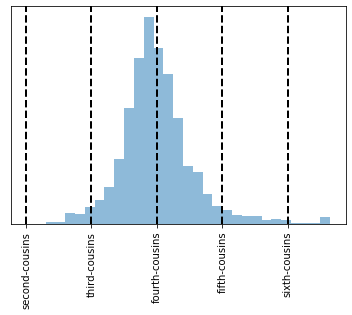

In [216]:
plt.hist(np.clip(-np.log2(share_med), 0, 14), alpha=0.5, bins=np.arange(5, 14.5, 0.3))
plt.xticks([5, 7, 9, 11, 13], 
           ['second-cousins', 'third-cousins', 'fourth-cousins', 'fifth-cousins', 'sixth-cousins'], rotation=90)
plt.grid(axis='x', which='major', linestyle='--', color='black', linewidth=2)
plt.yticks([])
plt.show()

# Consanguinity TDT

In [217]:
cyto = []
with open('../data/cytoBand%s.txt' % build, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0].startswith('chr') and pieces[0][3:] in chroms:
            cyto.append((pieces[0][3:], int(pieces[1]), int(pieces[2]), pieces[3], pieces[4]))

chrom_to_start_pos = [1]
for chrom in chroms[:-1]:
    chrom_length = max([x[2] for x in cyto if x[0]==chrom])
    chrom_to_start_pos.append(chrom_to_start_pos[-1] + chrom_length)
    

In [218]:
positions = set()
for filename in listdir(phase_dir):
    if filename.endswith('.phased.txt'):
        states, chrs, starts, ends, mult, individuals = pull_state('%s/%s' % (phase_dir, filename))
                    
        family_key = (filename.split('.')[0], min(individuals[:2]), max(individuals[:2]))
        share_mat = states[10, :]==0
        share_pat = states[11, :]==2
        
        positions.update(zip(chrs[share_mat | share_pat], starts[share_mat | share_pat]-1))
        positions.update(zip(chrs[share_mat | share_pat], starts[share_mat | share_pat]))
        positions.update(zip(chrs[share_mat | share_pat], ends[share_mat | share_pat]))
        positions.update(zip(chrs[share_mat | share_pat], ends[share_mat | share_pat]+1))
positions = sorted(positions)
position_to_index = dict([(x, i) for i, x in enumerate(positions)])
print('positions', len(positions))

positions 129027


In [219]:
xs = np.array([p+chrom_to_start_pos[chroms.index(str(c))] for c, p in positions])


In [220]:
def pull_phenotype(ped_file):
	sample_id_to_aff = dict()
	with open(ped_file, 'r') as f:	
		for line in f:
			pieces = line.strip().split('\t')
			if len(pieces) >= 6:
				fam_id, child_id, f_id, m_id, sex, aff = pieces[:6]
				sample_id_to_aff[child_id] = aff
	return sample_id_to_aff
sample_id_to_aff = pull_phenotype(ped_file)
is_affected = np.array([sample_id_to_aff[x]=='2' for x in children])

In [236]:
# position, unaff/aff, notrans/trans
consang_contingency = np.zeros((len(positions), 2, 2), dtype=int)
consang_total = []
already_seen = set()
for filename in listdir(phase_dir):
    if filename.endswith('.phased.txt'):
        states, chrs, starts, ends, mult, individuals = pull_state('%s/%s' % (phase_dir, filename))
                    
        family_key = (filename.split('.')[0], min(individuals[:2]), max(individuals[:2]))
        share_mat = states[10, :]==0
        share_pat = states[11, :]==2
        
        for i in np.where((share_mat & ~share_pat) | (~share_mat & share_pat))[0]:
            if states[12, i] != -1 and states[13, i] != -1 and individuals[2] not in already_seen:
                consang_contingency[np.arange(position_to_index[(chrs[i], starts[i])], position_to_index[(chrs[i], ends[i]+1)]),
                                    int(is_affected[child_to_index[individuals[2]]]), int(states[12, i]==states[13, i])] += 1
            if states[14, i] != -1 and states[15, i] != -1 and individuals[3] not in already_seen:
                consang_contingency[np.arange(position_to_index[(chrs[i], starts[i])], position_to_index[(chrs[i], ends[i]+1)]),
                                    int(is_affected[child_to_index[individuals[3]]]), int(states[14, i]==states[15, i])] += 1
        already_seen.update(individuals[2:])
        
        
        if is_affected[child_to_index[individuals[2]]] and (not is_affected[child_to_index[individuals[3]]]):
            consang_total.append([np.sum(mult[(states[12, :] != -1) & (states[12, :]==states[13, :])]),
                                  np.sum(mult[(states[14, :] != -1) & (states[14, :]==states[15, :])])
                                 ])
        elif (not is_affected[child_to_index[individuals[2]]]) and is_affected[child_to_index[individuals[3]]]:
            consang_total.append([np.sum(mult[(states[14, :] != -1) & (states[14, :]==states[15, :])]),
                                  np.sum(mult[(states[12, :] != -1) & (states[12, :]==states[13, :])])
                                 ])

In [237]:
consang_total = np.array(consang_total)
print(consang_total.shape)

(3209, 2)


In [238]:
print(consang_total)

[[ 1816731  4175378]
 [ 5422959 15447965]
 [  970555  2925453]
 ...
 [ 3077415  4304693]
 [ 5265277  1321963]
 [10774719  8651520]]


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


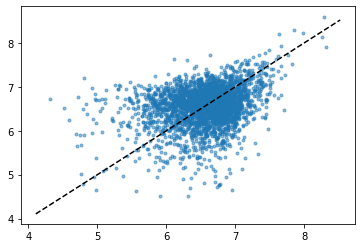

In [243]:
plt.scatter(np.log10(consang_total[:, 0]), np.log10(consang_total[:, 1]), alpha=0.5, marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.show()

In [245]:
print(scipy.stats.ttest_rel(consang_total[:, 0], consang_total[:, 1]))

Ttest_relResult(statistic=-1.441227744280997, pvalue=0.14961795272650855)


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


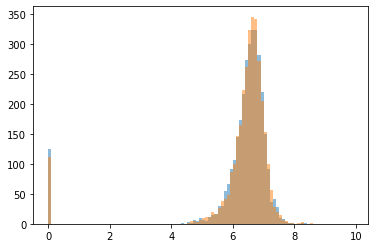

In [248]:
plt.hist(np.clip(np.log10(consang_total[:, 0]), 0, None), alpha=0.5, bins=np.arange(0, 10, 0.1))
plt.hist(np.clip(np.log10(consang_total[:, 1]), 0, None), alpha=0.5, bins=np.arange(0, 10, 0.1))
plt.show()

In [222]:
pvalues = np.ones((len(positions),))
for i in range(len(positions)):
    if np.all(np.sum(consang_contingency[i, :, :], axis=0)>0) and np.all(np.sum(consang_contingency[i, :, :], axis=1)>0):
        pvalues[i] = scipy.stats.chi2_contingency(consang_contingency[i, :, :])[1]

In [227]:
pvalues_binom = np.ones((len(positions), 2))
for i in range(len(positions)):
    pvalues_binom[i, 0] = scipy.stats.binom_test(consang_contingency[i, 0, 1], np.sum(consang_contingency[i, 0, :]), p=0.25)
    pvalues_binom[i, 1] = scipy.stats.binom_test(consang_contingency[i, 1, 1], np.sum(consang_contingency[i, 1, :]), p=0.25)
    
    

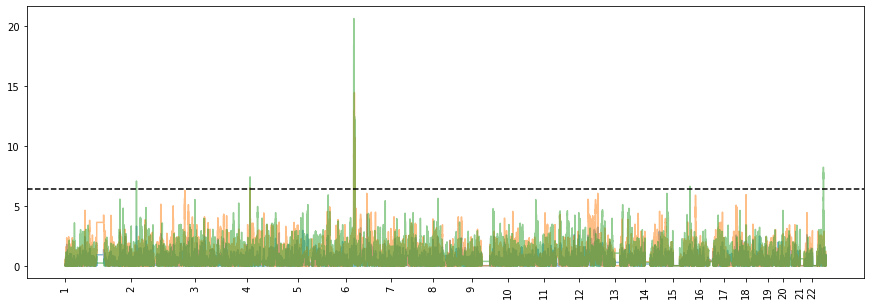

In [229]:
plt.figure(figsize=(15, 5))
plt.plot(xs, -np.log10(pvalues), alpha=0.5)
#plt.plot(xs, -np.log10(pvalues_binom[:, 0]), alpha=0.5)
plt.plot(xs, -np.log10(pvalues_binom[:, 1]), alpha=0.5)

plt.xticks(chrom_to_start_pos, chroms, rotation=90)
plt.axhline(-np.log10(0.05/np.sum(pvalues != 1)), color='black', linestyle='--')
plt.show()

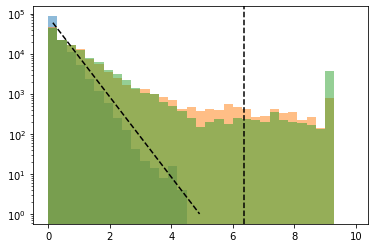

In [230]:
binsize = 0.3
n = np.sum(pvalues!=1)
plt.hist(np.clip(-np.log10(pvalues), None, 9), log=True, bins=np.arange(0, 10, binsize), alpha=0.5)
plt.hist(np.clip(-np.log10(pvalues_binom[:, 0]), None, 9), log=True, bins=np.arange(0, 10, binsize), alpha=0.5)
plt.hist(np.clip(-np.log10(pvalues_binom[:, 1]), None, 9), log=True, bins=np.arange(0, 10, binsize), alpha=0.5)
plt.plot([binsize/2, np.log10(n*(1-(10**-binsize))) + binsize/2], 
             [n*(1-(10**-binsize)), 1], color='black', linestyle='--')  
plt.axvline(-np.log10(0.05/np.sum(pvalues != 1)), color='black', linestyle='--')
plt.show()